# Analysis of JPMAP iterations
You must first run JPMAP with `--save-iters` flag to store JPMAP iterations (see `run_experiments.sh`)

In [1]:
import os
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
import torch
from utils import *

# For LaTeX in matplotlib figures
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

device = cuda


## Load experiments parameters

In [2]:
exp_name = 'missing_perc80_alpha1'  # see "run_experiments.sh"
experiment = os.path.join('experiments/mnist', exp_name)

In [3]:
with open(os.path.join(experiment, 'experiment_args.json')) as json_file:
    args = json.load(json_file)

    #alpha = args['alpha']*np.sqrt(n_pixels)/255
    model = args['model']
    n_samples = args['n_samples']

In [4]:
models_folder = 'pretrained_models'
model_path = os.path.join(models_folder, model)
vae = load_vae_model(model_path, device=device)
vae.eval()
vae.freeze()

## Show results

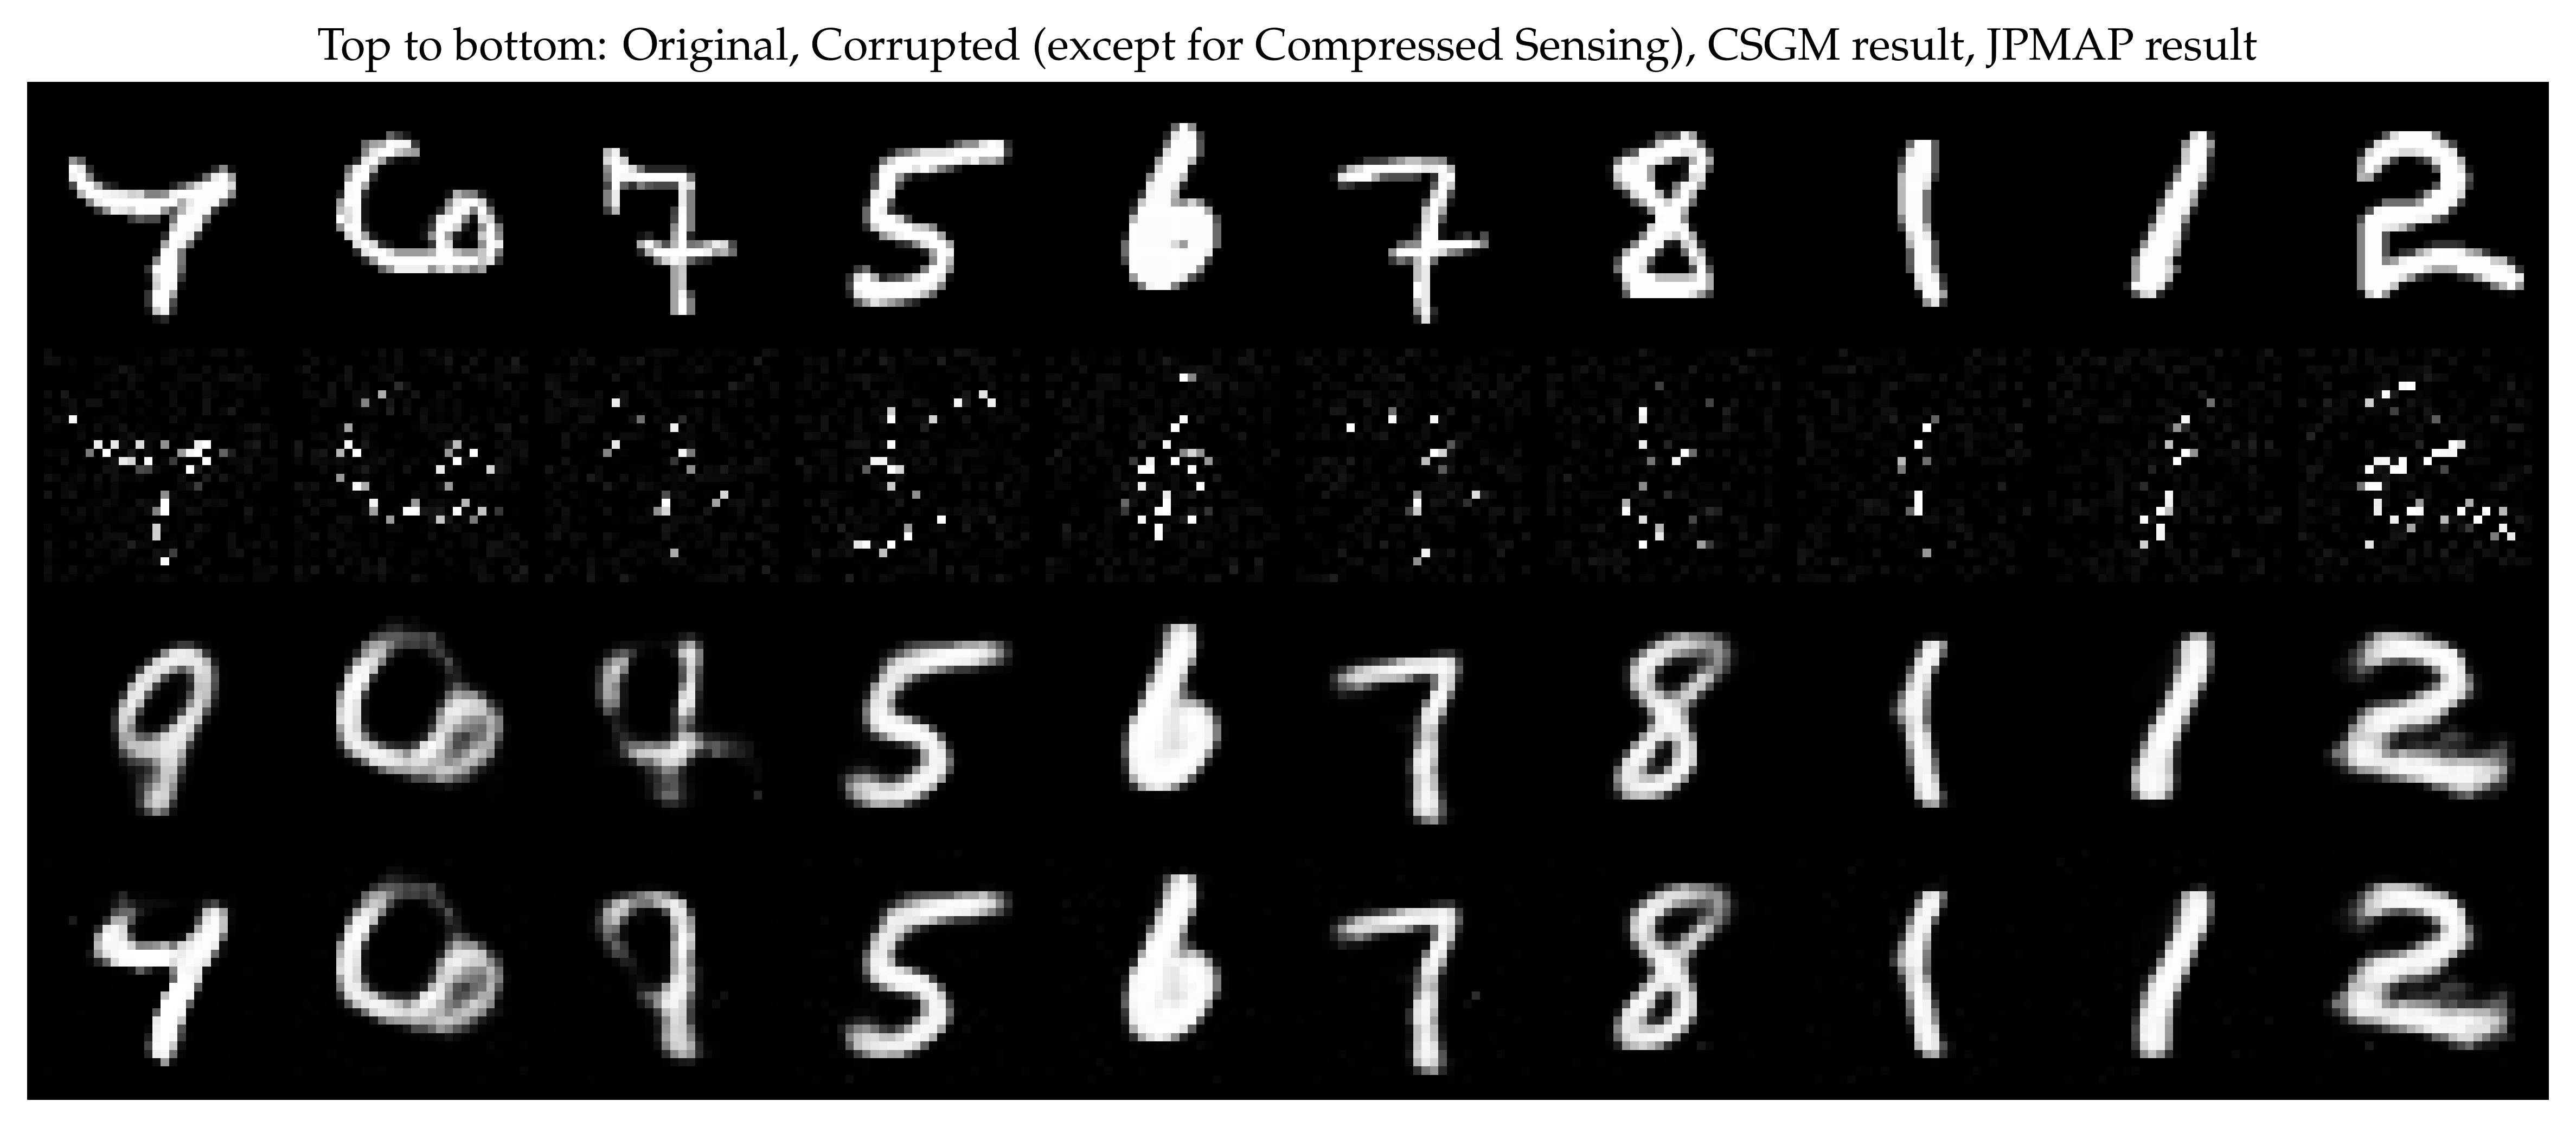

In [5]:
results = plt.imread(os.path.join(experiment, 'results_' + exp_name + '.png'))
plt.figure(figsize=(12,12), dpi=500)
plt.imshow(results); plt.axis('off');
plt.title('Top to bottom: Original, Corrupted (except for Compressed Sensing), CSGM result, JPMAP result');

## Load one restoration

In [6]:
print('Number of samples =', n_samples)

Number of samples = 10


In [7]:
ind = 0  # between 0 and (n_samples-1)
xiters_jpmap = np.load(os.path.join(experiment, 'xiters_jpmap_%2d.npy' % ind))
ziters_jpmap = np.load(os.path.join(experiment, 'ziters_jpmap_%2d.npy' % ind))
#n_pixels = xiters_jpmap[0].size

In [8]:
mu_x, gamma_x = vae.decoder(torch.from_numpy(ziters_jpmap).to(device))
Gziters_jpmap = mu_x.cpu().detach().numpy()
print('gamma_x =', float(gamma_x))

gamma_x = 0.10996052622795105


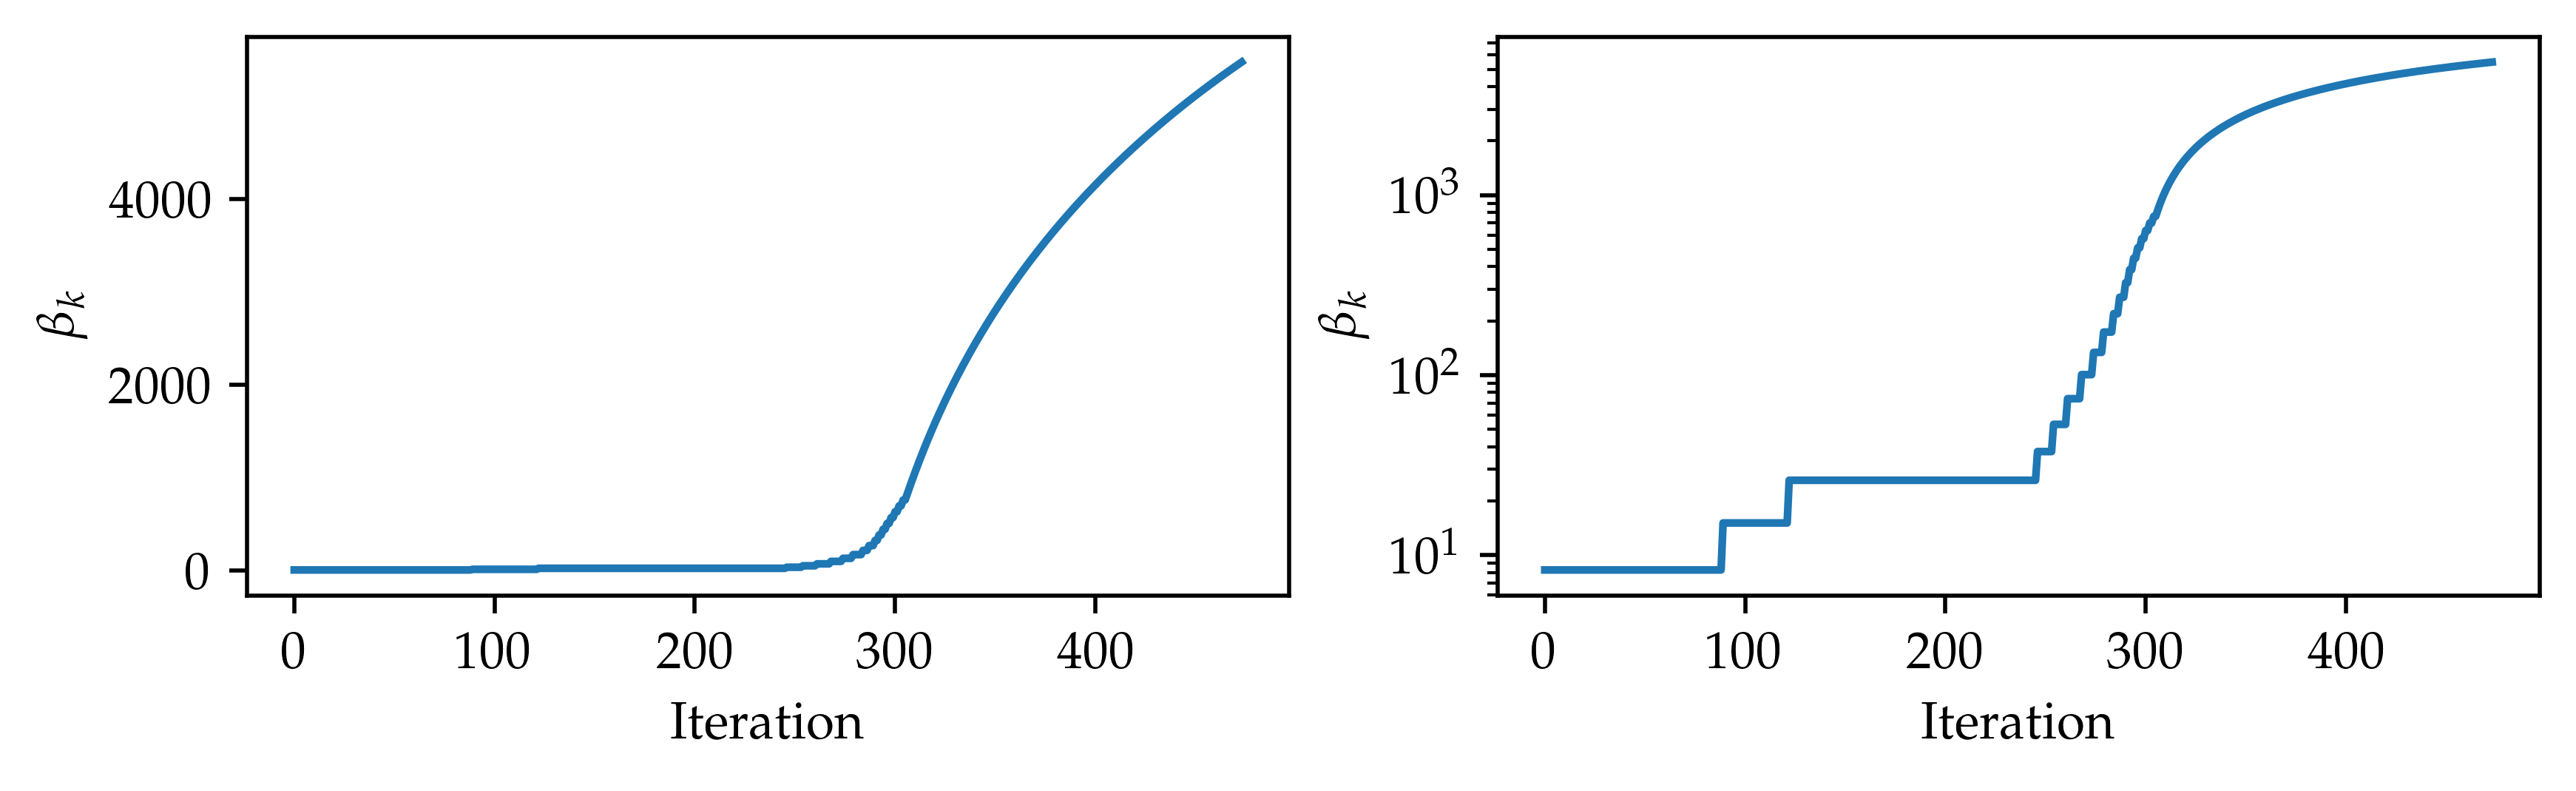

In [9]:
beta_k = np.load(os.path.join(experiment, 'beta_k_%2d.npy' % ind), allow_pickle=True)
#gamma_k = 1/beta_k
plt.figure(figsize=(8,2), dpi=500)
plt.subplot(121), plt.plot(beta_k), plt.xlabel('Iteration'), plt.ylabel('$\\beta_k$');
plt.subplot(122), plt.semilogy(beta_k), plt.xlabel('Iteration'), plt.ylabel('$\\beta_k$');
#plt.subplot(223), plt.plot(gamma_k), plt.xlabel('Iteration'), plt.ylabel('$\gamma_k$');
#plt.subplot(224), plt.semilogy(gamma_k), plt.xlabel('Iteration'), plt.ylabel('$\gamma_k$');

## Plot `xiters`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


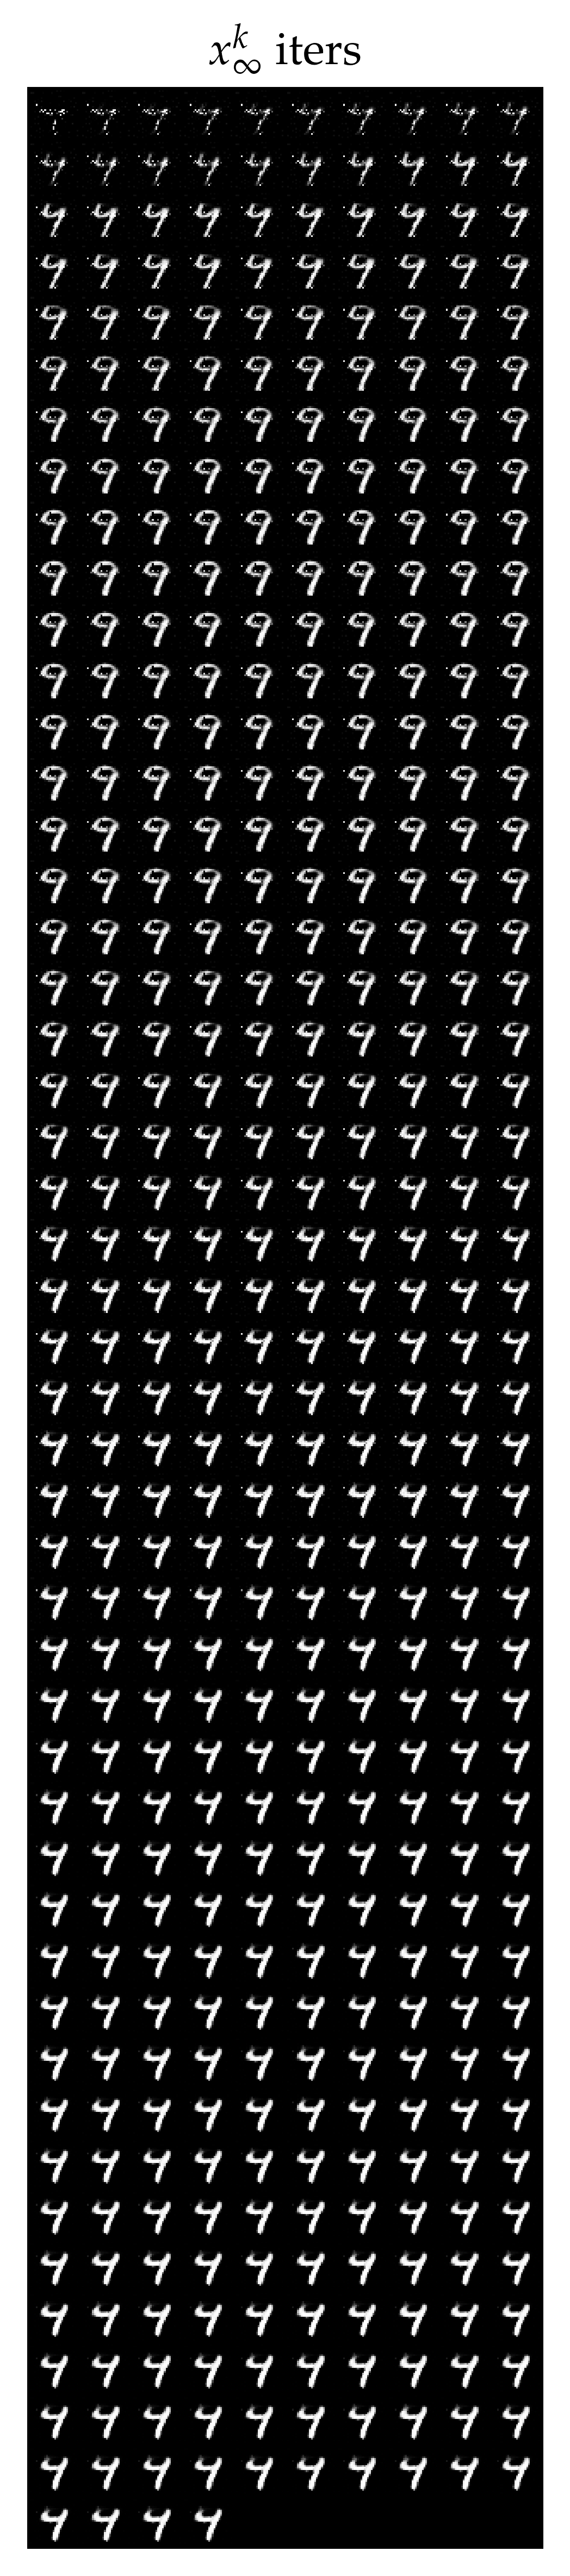

In [10]:
show_image = make_grid(torch.from_numpy(xiters_jpmap), nrow=10).permute(1,2,0)
plt.figure(figsize=(12,12), dpi=500)
plt.imshow(show_image);
plt.title('$x^k_\infty$ iters');
plt.axis('off');

## Images generated by `ziters`

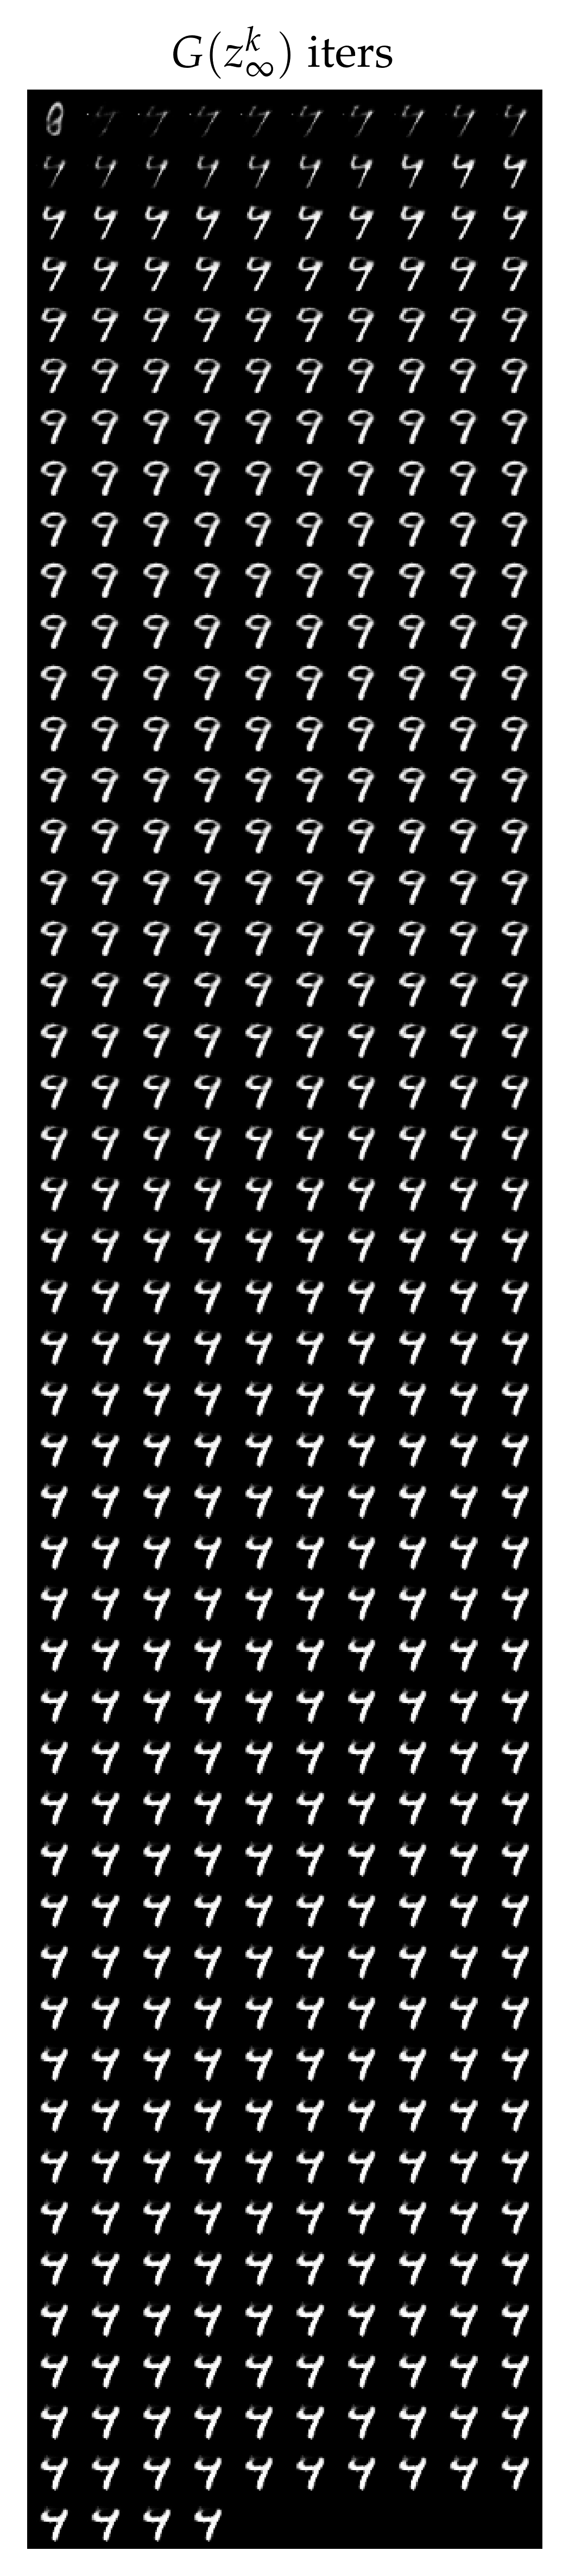

In [11]:
show_image2 = make_grid(torch.from_numpy(Gziters_jpmap), nrow=10).permute(1,2,0)
plt.figure(figsize=(12,12), dpi=500)
plt.imshow(show_image2);
plt.title('$G(z^k_\infty)$ iters')
plt.axis('off');

## Distances

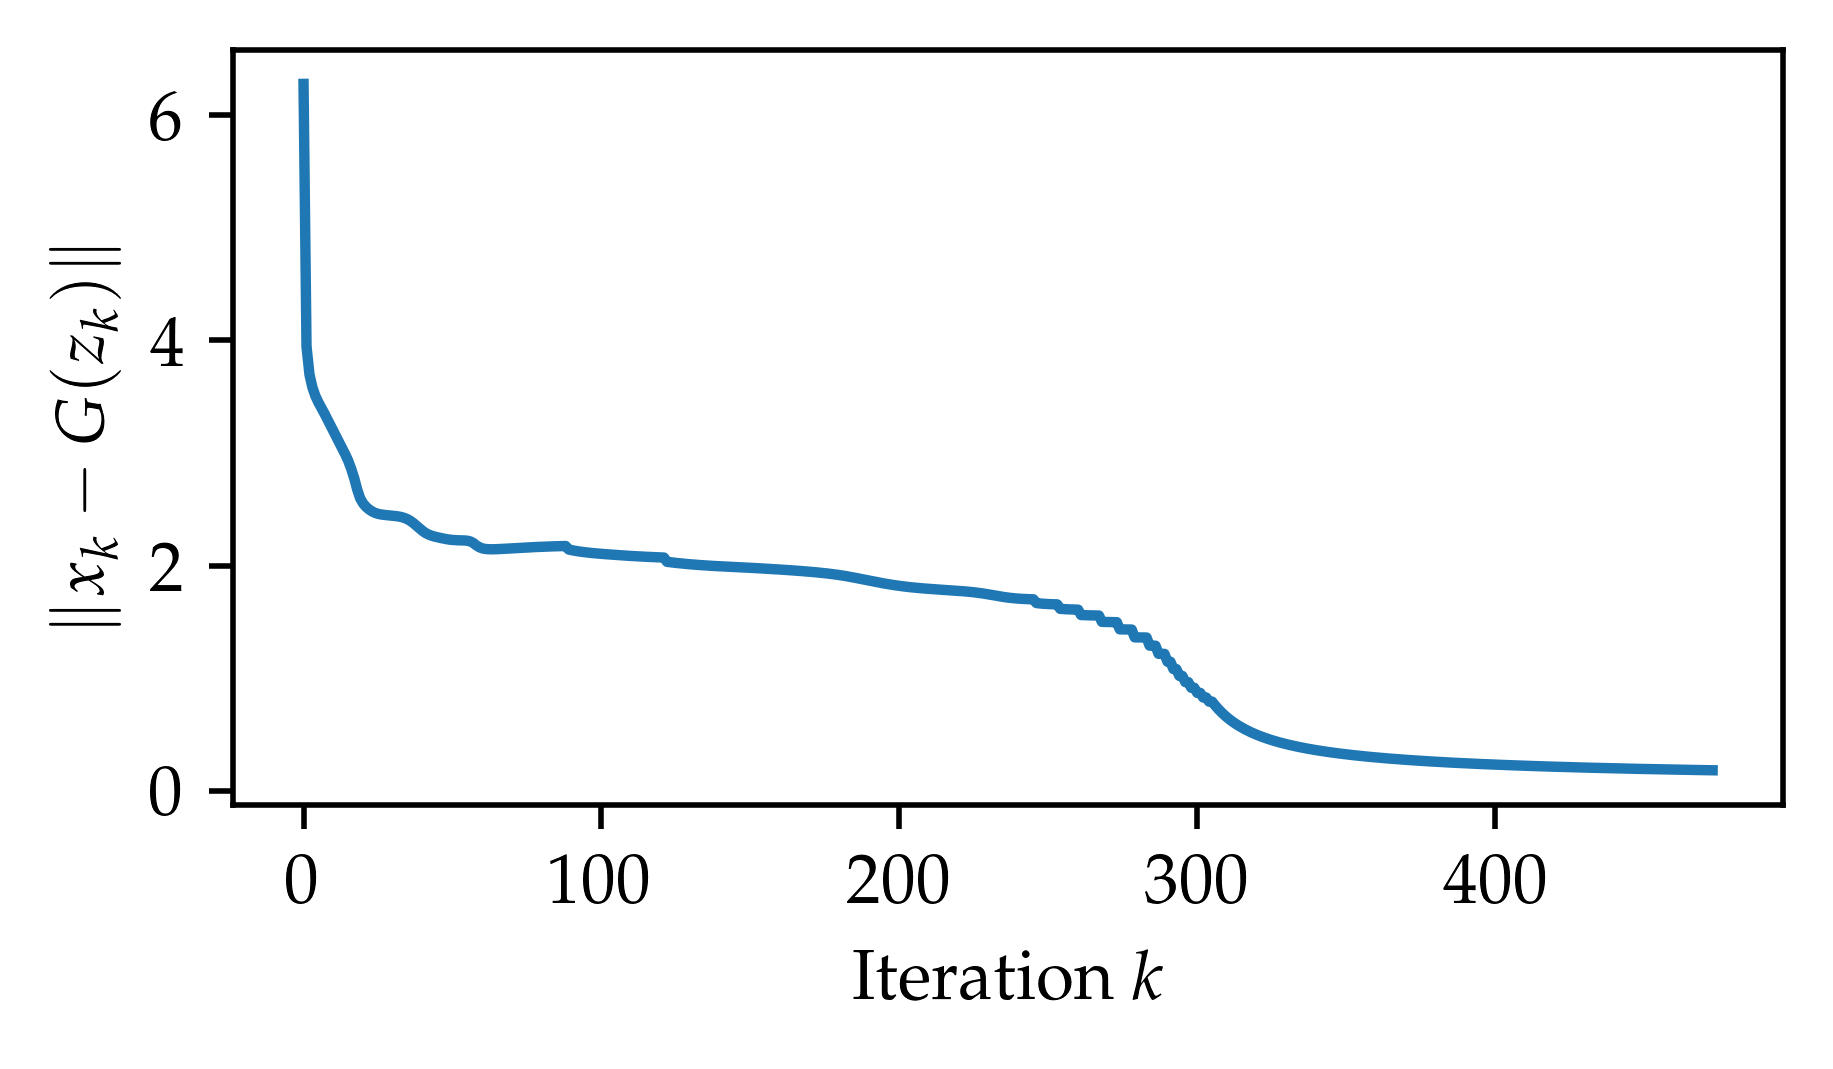

In [12]:
n = xiters_jpmap.shape[0]
dif = (Gziters_jpmap-xiters_jpmap).reshape(n,-1)
norms = norm(dif, axis=1)

plt.figure(figsize=(4,2), dpi=500)
plt.plot(norms);
plt.xlabel('Iteration $k$');
plt.ylabel('$\|x_k - G(z_k)\|$');